In [20]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

# Data Cleansing

## Merge two raw datasets

In [21]:
##data = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/Fraud-Detection-master/Fraud_Data/Fraud_Data.csv',parse_dates = ['signup_time','purchase_time'])
data = pd.read_csv('/Users/adamichael/Dropbox/Job/Data/Fraud-Detection-master/Fraud_Data/Fraud_Data.csv',parse_dates = ['signup_time','purchase_time'])
data.head(10)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [22]:
##address_data = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/Fraud-Detection-master/Fraud_Data/IpAddress_to_Country.csv')
address_data = pd.read_csv('/Users/adamichael/Dropbox/Job/Data/Fraud-Detection-master/Fraud_Data/IpAddress_to_Country.csv')
address_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [23]:
countries = []
for i in range(len(data)):
    ip_address = data.loc[i,'ip_address']
    tmp = address_data[(address_data['lower_bound_ip_address']<=ip_address) & 
                      (address_data['upper_bound_ip_address']>=ip_address)]
    if len(tmp)==1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
data['countries'] = countries


In [24]:
data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,countries
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,NA
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
countries         151112 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


## Outliers/Missing Data Handling

In [26]:
data.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
countries         0
dtype: int64

In [27]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,151112.0,2.001710e+05,1.153693e+05,2.000000,1.006425e+05,1.999580e+05,3.000540e+05,4.000000e+05
purchase_value,151112.0,3.693537e+01,1.832276e+01,9.000000,2.200000e+01,3.500000e+01,4.900000e+01,1.540000e+02
age,151112.0,3.314070e+01,8.617733e+00,18.000000,2.700000e+01,3.300000e+01,3.900000e+01,7.600000e+01
ip_address,151112.0,2.152145e+09,1.248497e+09,52093.496895,1.085934e+09,2.154770e+09,3.243258e+09,4.294850e+09
class,151112.0,9.364577e-02,2.913362e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [28]:
data.describe(include='object').transpose()

,count,unique,top,freq
device_id,151112,137956,CQTUVBYIWWWBC,20
source,151112,3,SEO,60615
browser,151112,5,Chrome,61432
sex,151112,2,M,88293
countries,151112,182,United States,58049


In [29]:
data['countries'].value_counts()

United States                      58049
NA                                 21966
China                              12038
Japan                               7306
United Kingdom                      4490
Korea Republic of                   4162
Germany                             3646
France                              3161
Canada                              2975
Brazil                              2961
Italy                               1944
Australia                           1844
Netherlands                         1680
Russian Federation                  1616
India                               1310
Taiwan; Republic of China (ROC)     1237
Mexico                              1121
Sweden                              1090
Spain                               1027
South Africa                         838
Switzerland                          785
Poland                               729
Argentina                            661
Indonesia                            649
Norway          

In [30]:
country_list = data['countries'].value_counts().to_frame().reset_index().rename(columns={'index':'country','countries':'count'})
main_country = list(country_list[country_list['count']>100]['country'])
main_country.remove('NA')
data['countries']=data['countries'].apply(lambda x: x if x in main_country else 'Other')

In [31]:
data.shape

(151112, 12)

# Feature Engineering

## Time difference

In [32]:
## if time difference is too short, it is highly likely a fraud.
time_diff = data['purchase_time']-data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff']=time_diff

## Check user number for unique device

In [33]:
## if multiple users share same device, it is more likely a fraud activity
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
device_num.head()
data = data.merge(device_num, how='left', on='device_id')

## Check user number for unique IP address

In [34]:
## if multiple users share same IP, it is more likely a fraud activity
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

## Sign up/Purchase Day of Week and Week

In [35]:
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,countries,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Other,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


# Exploratory Data Analysis

## Correlation Analysis

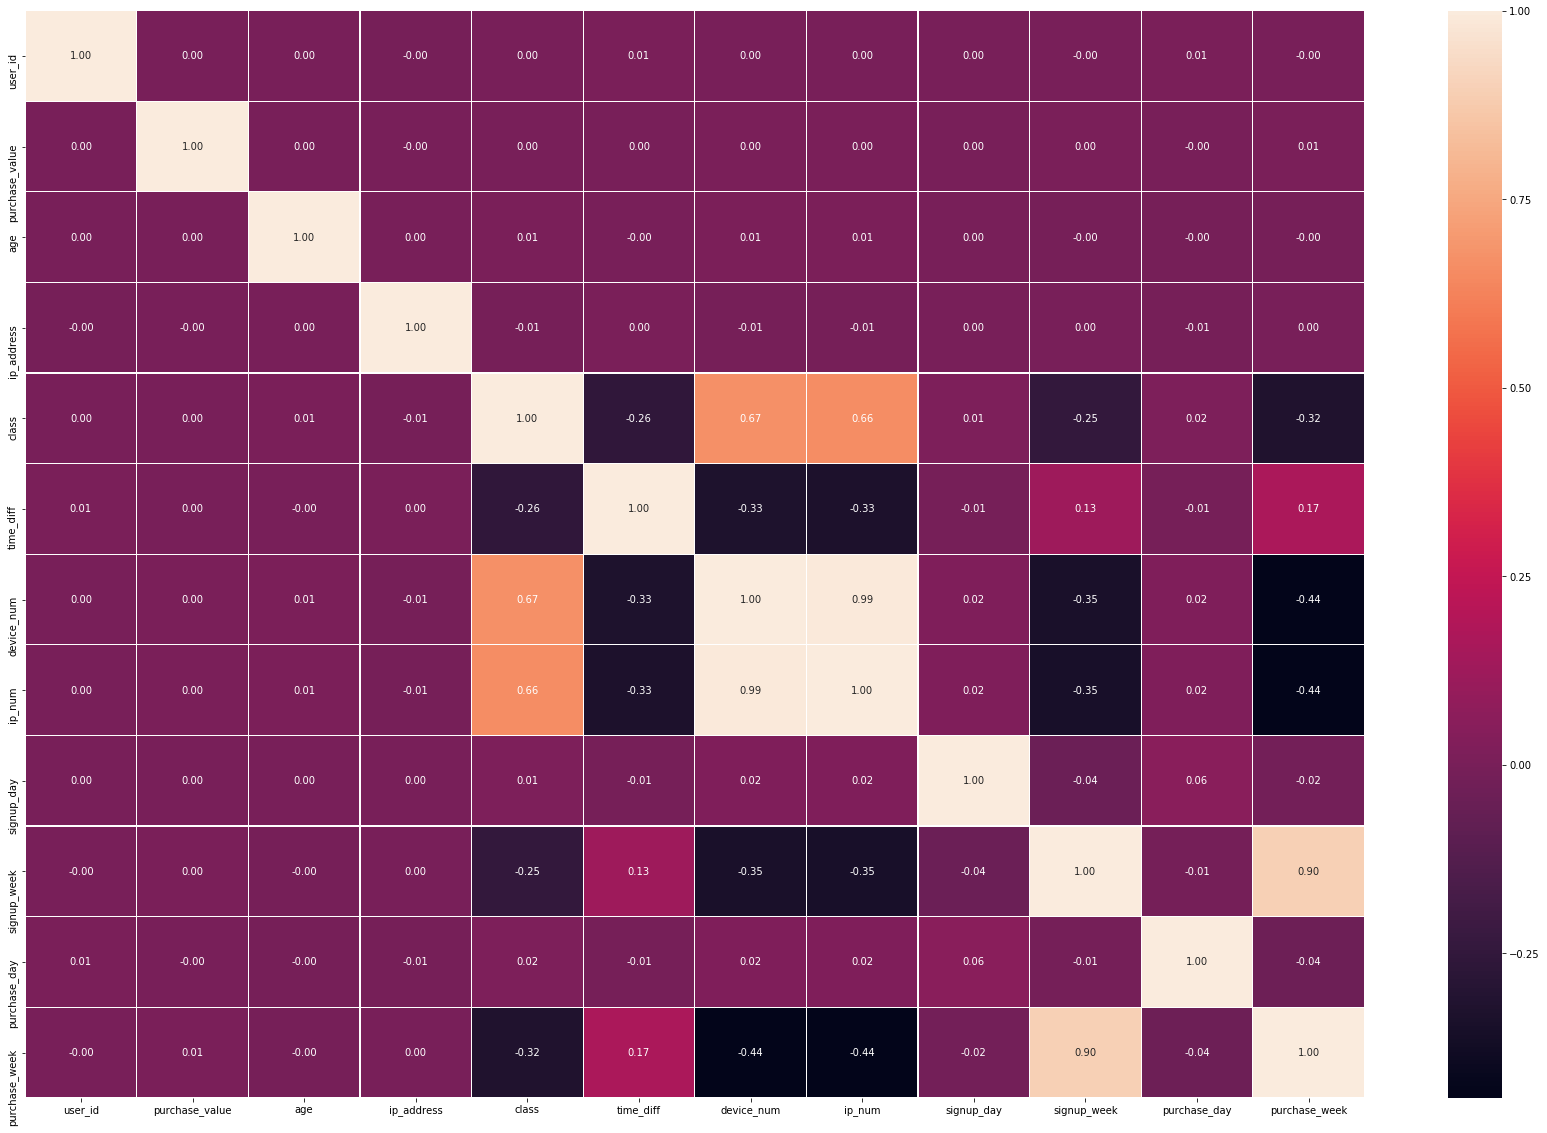

In [36]:
corr = data[data.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

## Target VS Categorical Data

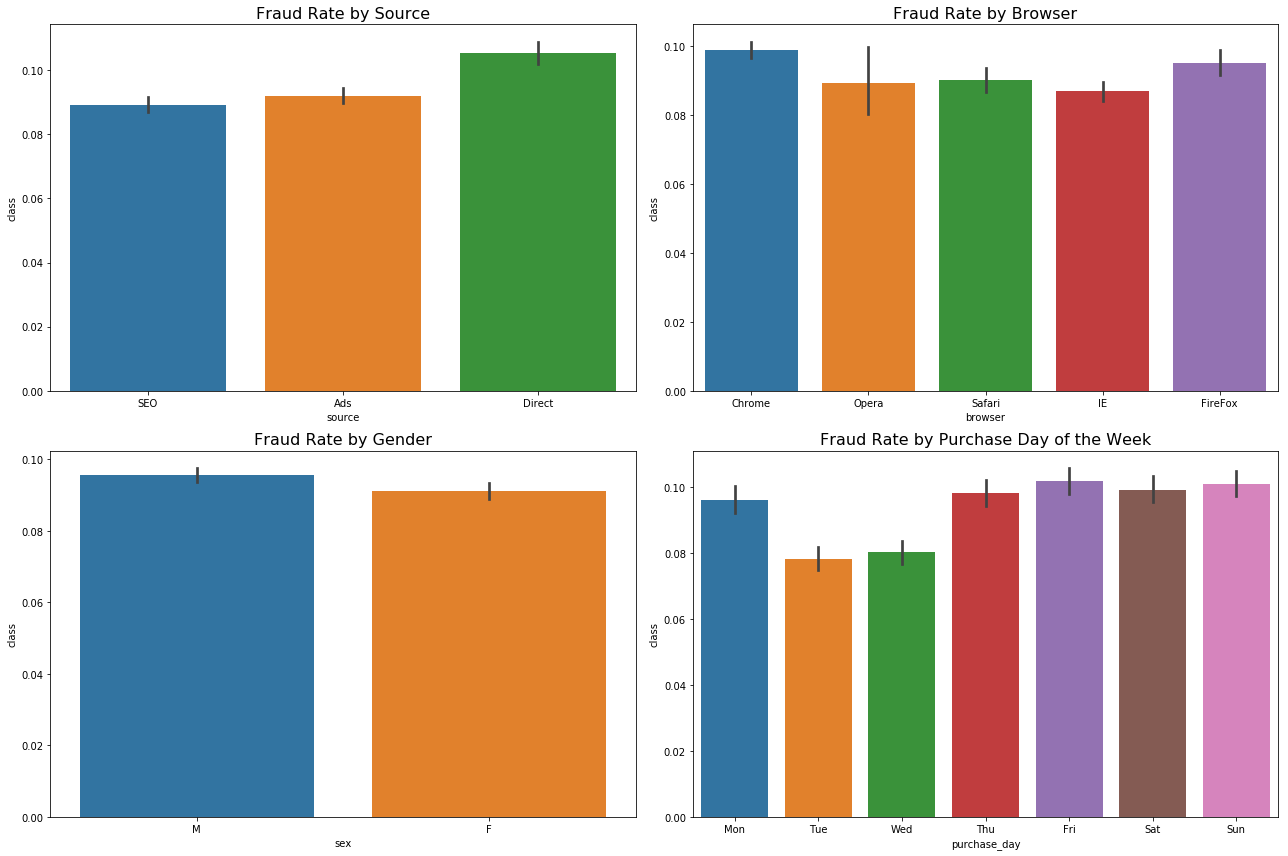

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
sns.barplot(x='source', y='class', data=data, ax=ax[0,0])
ax[0,0].set_title('Fraud Rate by Source', fontsize=16)
sns.barplot(x='browser', y='class', data=data, ax=ax[0,1])
ax[0,1].set_title('Fraud Rate by Browser', fontsize=16)
sns.barplot(x='sex', y='class', data=data, ax=ax[1,0])
ax[1,0].set_title('Fraud Rate by Gender', fontsize=16)
sns.barplot(x='purchase_day', y='class', data=data, ax=ax[1,1])
ax[1,1].set_title('Fraud Rate by Purchase Day of the Week', fontsize=16)
ax[1,1].set_xticks(np.arange(7))
ax[1,1].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

plt.tight_layout()
plt.show()

## Target VS Continuous Data

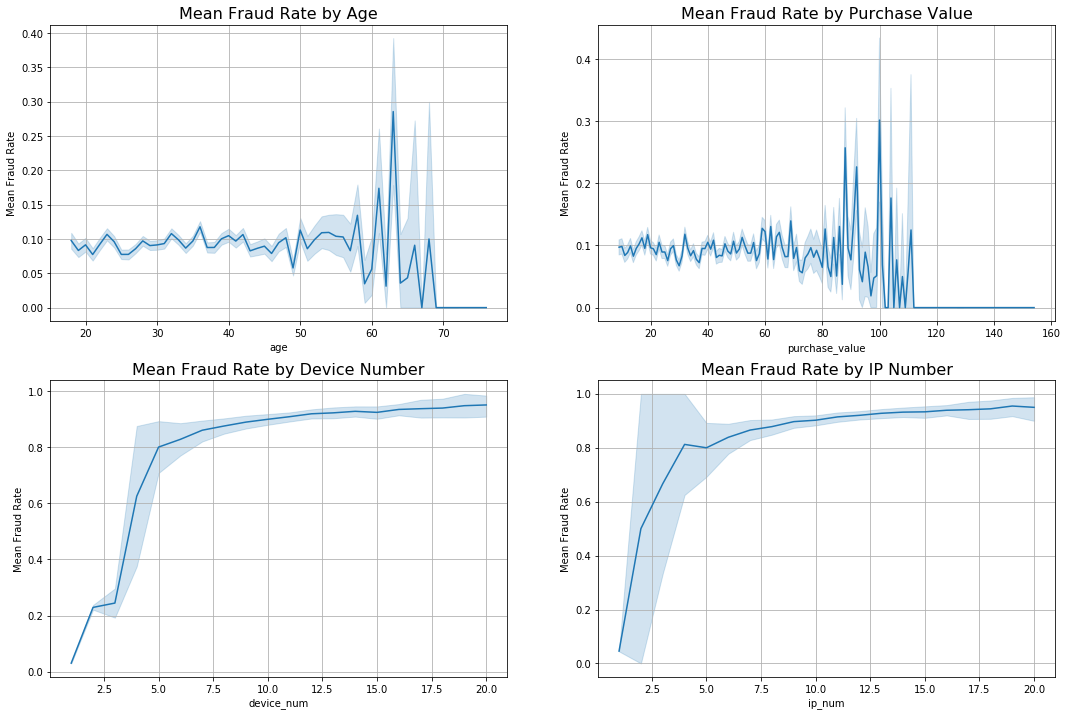

In [38]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,12))
sns.lineplot(x='age',y='class',data=data,ax=ax[0,0])
ax[0,0].set_title('Mean Fraud Rate by Age', fontsize = 16)
ax[0,0].set_ylabel('Mean Fraud Rate')
ax[0,0].grid()
sns.lineplot(x='purchase_value',y='class',data=data,ax=ax[0,1])
ax[0,1].set_title('Mean Fraud Rate by Purchase Value', fontsize = 16)
ax[0,1].set_ylabel('Mean Fraud Rate')
ax[0,1].grid()
sns.lineplot(x='device_num',y='class',data=data,ax=ax[1,0])
ax[1,0].set_title('Mean Fraud Rate by Device Number', fontsize = 16)
ax[1,0].set_ylabel('Mean Fraud Rate')
ax[1,0].grid()
sns.lineplot(x='ip_num',y='class',data=data,ax=ax[1,1])
ax[1,1].set_title('Mean Fraud Rate by IP Number', fontsize = 16)
ax[1,1].set_ylabel('Mean Fraud Rate')
ax[1,1].grid()
plt.show()

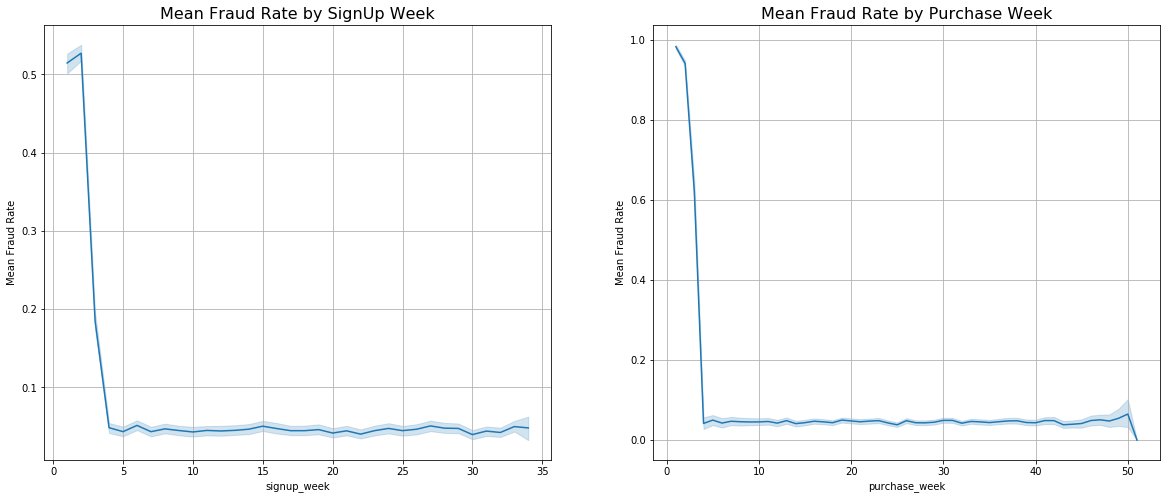

In [39]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
sns.lineplot(x='signup_week',y='class',data=data,ax=ax[0])
ax[0].set_title('Mean Fraud Rate by SignUp Week', fontsize = 16)
ax[0].set_ylabel('Mean Fraud Rate')
ax[0].grid()
sns.lineplot(x='purchase_week',y='class',data=data,ax=ax[1])
ax[1].set_title('Mean Fraud Rate by Purchase Week', fontsize = 16)
ax[1].set_ylabel('Mean Fraud Rate')
ax[1].grid()

plt.show()

# Random Forest Model Fitting

## Select model features and targets

In [96]:
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'countries', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,countries,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,Other,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


## Initiate the model

In [97]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 days 8 hours 1 min
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,4 months and 27 days !!!
H2O_cluster_name:,H2O_from_python_adamichael_hb4hi6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.739 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


## Categorize all factor columns

In [98]:
h2o_df = H2OFrame(data)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'countries', 'class']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,countries,time_diff,device_num,ip_num,class
type,enum,int,enum,int,int,enum,enum,enum,int,enum,int,int,int,enum
mins,,1.0,,1.0,9.0,,,,18.0,,1.0,1.0,1.0,
mean,,16.50174043093852,,24.65857112605208,36.93537243898572,,,,33.14070358409688,,40942.584427444526,1.6843665625496358,1.602718513420507,
maxs,,34.0,,51.0,154.0,,,,76.0,,86399.0,20.0,20.0,
sigma,,9.814287461798857,,11.651556782719457,18.322762148662136,,,,8.617733490961474,,26049.66190211837,2.6169536028041716,2.596239527375845,
zeros,,0,,0,0,,,,0,,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,9.0,5,16.0,34.0,SEO,Chrome,M,39.0,Japan,13882.0,1.0,1.0,0
1,6,23.0,0,24.0,16.0,Ads,Chrome,F,53.0,United States,17944.0,1.0,1.0,0
2,3,1.0,3,1.0,15.0,SEO,Opera,M,53.0,United States,1.0,12.0,12.0,1


## Split the train/test data

In [99]:
strat_split = h2o_df['class'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

## Split the feature/target

In [100]:
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'countries', 'time_diff', 'device_num', 'ip_num']
target = 'class'

## Build model

In [112]:
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [113]:
model.score_history()


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-24 19:14:12,0.050 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-02-24 19:14:13,0.343 sec,1.0,0.316734,0.834808,0.958595,0.942358,1.916928,0.094070,0.265740,1.902968,0.777729,0.461264,6.943622,0.069331
2,,2021-02-24 19:14:13,0.533 sec,2.0,0.320636,0.695042,0.963606,0.951410,1.936362,0.089031,0.212279,0.708791,0.804910,0.644319,10.173392,0.045927
3,,2021-02-24 19:14:13,0.780 sec,3.0,0.338562,0.599421,0.962435,0.955911,1.955951,0.094502,0.205894,0.411573,0.820124,0.675714,10.594359,0.044405
4,,2021-02-24 19:14:13,1.083 sec,4.0,0.340796,0.550357,0.964743,0.960248,1.964755,0.091148,0.204283,0.334298,0.824992,0.683058,10.641215,0.044383
5,,2021-02-24 19:14:14,1.404 sec,5.0,0.337632,0.495271,0.969900,0.966439,1.972773,0.084778,0.203630,0.287825,0.827915,0.689655,10.669604,0.044206
6,,2021-02-24 19:14:14,1.735 sec,6.0,0.333634,0.453207,0.975131,0.972008,1.977794,0.077146,0.203381,0.273573,0.827811,0.690616,10.669604,0.044074
7,,2021-02-24 19:14:14,2.078 sec,7.0,0.331822,0.422012,0.978175,0.975850,1.982454,0.072684,0.203359,0.260671,0.828642,0.692821,10.679152,0.044074
8,,2021-02-24 19:14:15,2.449 sec,8.0,0.330589,0.392359,0.981553,0.979861,1.986919,0.068634,0.203339,0.246830,0.830809,0.694294,10.679152,0.044162
9,,2021-02-24 19:14:15,2.827 sec,9.0,0.328223,0.366115,0.984705,0.983521,1.990576,0.062459,0.203246,0.236765,0.830982,0.696096,10.679152,0.044052


## Show feature importance

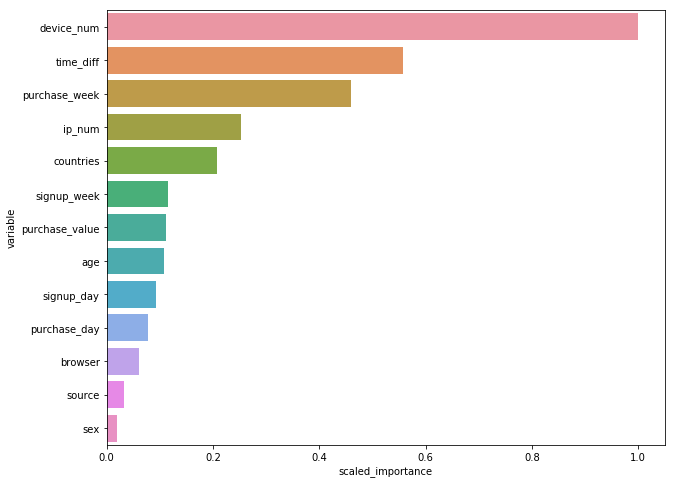

In [114]:
importance = model.varimp(use_pandas=True)
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

## Make auc curve

In [115]:
## train/test are all H2O frame, to fetch specific columns values, need to covert back to data frame using as_data_frame()
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
## to predict the target on certain dataset in H2O, just use model.predict(dataset), 'p0' is the probability of class 0, and 
## "p1" is the probability of class 1
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [116]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [117]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41088
           1       1.00      0.53      0.69      4245

   micro avg       0.96      0.96      0.96     45333
   macro avg       0.98      0.76      0.83     45333
weighted avg       0.96      0.96      0.95     45333



In [118]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)


In [119]:
train_fpr

array([0.        , 0.        , 0.        , ..., 0.99156175, 0.99158261,
       1.        ])

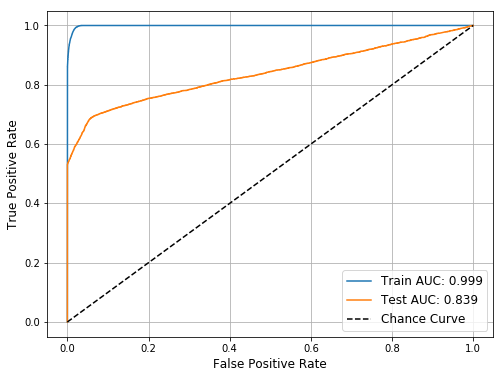

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


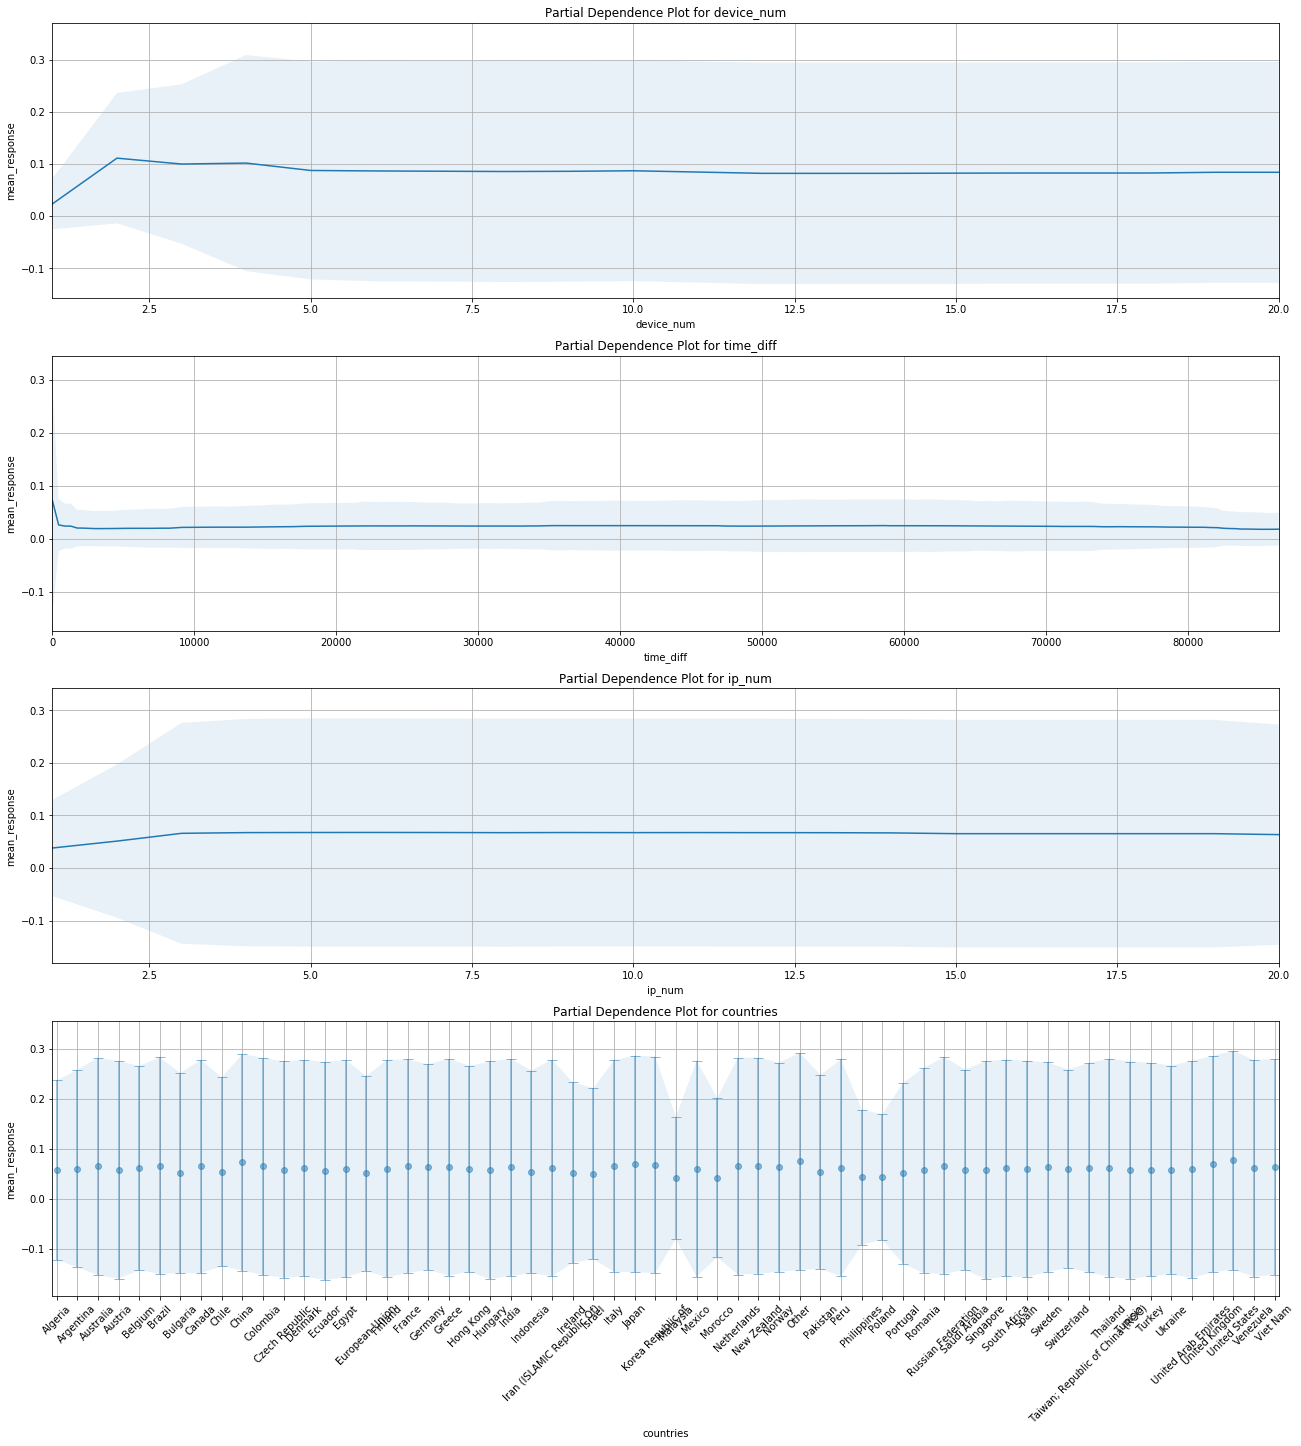

In [121]:
cols = ['device_num', 'time_diff', 'ip_num','countries']
_ = model.partial_plot(data=train, cols=cols, nbins=200, figsize=(18, 20))